<a href="https://colab.research.google.com/github/daniyal9538/CID/blob/master/AlexNet_on_MNIST_with_manually_added_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preamble and Introduction

I wanted to investigate how adding additional features to an image affect the predictions of a convolution neural network.Specifically, i want to see if adding new features on an additional channel of the image, can change the prediction behaviour of the cnn, whilst the cnn retains the prediction behavior from the unmodified image. Additionally, i wanted to see how a standard and well tested CNN ( such as alexNet) can be modified to deal with a suboptimal image.


AlexNet was designed to compete in the ImageNet LSVRC-2010 contest. The input to AlexNet were RGB images of resolution 256x256. 
The dataset to be used on this experiment will be the standard MNIST dataset. The images are greysclae (Single channel) and of resolution 28x28. The image images from the mnist dataset is massively different from the images that were used to train AlexNet.

#Training MNIST on a standard AlexNet architecture

The architecture is borrowed from the paper: "ImageNet Classification with Deep Convolutional
Neural Networks"
I will use the tflearn library to build this neural network. Im personally comfortable with tflearn and its fairly simple to edit the neural network layers with tflearn as well.

In [0]:
import tensorflow as tf

In [0]:
!pip install -q tflearn
import numpy as np
import time
from random import shuffle
from matplotlib import pyplot as plt

In [3]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d,avg_pool_2d, conv_3d, max_pool_3d, avg_pool_3d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.merge_ops import merge

Instructions for updating:
Colocations handled automatically by placer.


The dataset is downloaded with a 1 hot encoding to make it easier to manage and edit

In [4]:
import tflearn.datasets.mnist as mnist

x_train, y_train,x_test, y_test = mnist.load_data(one_hot=True)

Succesfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting mnist/train-images-idx3-ubyte.gz
Succesfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting mnist/train-labels-idx1-ubyte.gz
Succesfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting mnist/t10k-images-idx3-ubyte.gz
Succesfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting mnist/t10k-labels-idx1-ubyte.gz


By default the feature vectors are not in the correct shape so it is neccesary to reshape them. Thw vectors need to be in the shape of 28x28 dimensinal vectors with a single channel (as the input image is grayscale).

In [5]:
print(x_train.shape, x_test.shape)
x_train=np.reshape(x_train, (-1, 28, 28, 1))
x_test=np.reshape(x_test, (-1, 28, 28, 1))
print("After Reshaping")
print(x_train.shape, x_test.shape)

(55000, 784) (10000, 784)
After Reshaping
(55000, 28, 28, 1) (10000, 28, 28, 1)


#Defining models and running initial tests

This alexnet model is edited to work with a label space of size 10 and with a single channel image.
All training runs shall be ran for 5 epochs with a LR = 1e-3. These hyperparameters will not change for the sake of consistency across the trials

Additional Note: The activation function in the fully connected layers should be ReLU as well. But i did not catch that mistake until i was reviewing the project. 
However, i believe that it would not have had such a big impact on the final results.

In [0]:
#set hyper parameters
WIDTH = 28
HEIGHT = 28
LR = 1e-3
epochs = 5

In [0]:
def alexnet2(width, height, lr, output=3):
    network = input_data(shape=[None, width, height, 1], name='input')
    network = conv_2d(network, 96, 11, strides=4, activation='relu')
    network = max_pool_2d(network, 3, strides=2)
    network = local_response_normalization(network)
    network = conv_2d(network, 256, 5, activation='relu')
    network = max_pool_2d(network, 3, strides=2)
    network = local_response_normalization(network)
    network = conv_2d(network, 384, 3, activation='relu')
    network = conv_2d(network, 384, 3, activation='relu')
    network = conv_2d(network, 256, 3, activation='relu')
    network = max_pool_2d(network, 3, strides=2)
    network = conv_2d(network, 256, 5, activation='relu')
    network = max_pool_2d(network, 3, strides=2)
    network = local_response_normalization(network)
    network = conv_2d(network, 384, 3, activation='relu')
    network = conv_2d(network, 384, 3, activation='relu')
    network = conv_2d(network, 256, 3, activation='relu')
    network = max_pool_2d(network, 3, strides=2)
    network = local_response_normalization(network)
    network = fully_connected(network, 4096, activation='tanh')
    network = dropout(network, 0.5)
    network = fully_connected(network, 4096, activation='tanh')
    network = dropout(network, 0.5)
    network = fully_connected(network, 4096, activation='tanh')
    network = dropout(network, 0.5)
    network = fully_connected(network, 4096, activation='tanh')
    network = dropout(network, 0.5)
    network = fully_connected(network, output, activation='softmax')
    network = regression(network, optimizer='momentum',
                         loss='categorical_crossentropy',
                         learning_rate=lr, name='targets')

    model = tflearn.DNN(network, checkpoint_path='model_alexnet',
                        max_checkpoints=1, tensorboard_verbose=0, tensorboard_dir='log')

    return model

In [8]:
model1 = alexnet2(WIDTH, HEIGHT, LR, output=10)

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


In [9]:
model1.fit({'input': x_train}, {'targets': y_train}, n_epoch = epochs, validation_set = ({'input': x_test}, {'targets': y_test}),
                snapshot_step = 2500, show_metric = True)

Training Step: 4299  | total loss: 2.30405 | time: 59.797s
| Momentum | epoch: 005 | loss: 2.30405 - acc: 0.0948 -- iter: 54976/55000
Training Step: 4300  | total loss: 2.30366 | time: 62.266s
| Momentum | epoch: 005 | loss: 2.30366 - acc: 0.0963 | val_loss: 2.30120 - val_acc: 0.1135 -- iter: 55000/55000
--


#First Results and Changes

The result are predictably bad. AlexNet was not designed to deal for classification of such low resolution images on such a limited dataset.

The next step is to edit AlexNet to see whether any changes in the convolution and padding layers alone would improve accuracy.

Apart for the first 2 2d convolution layers, the window sizes of all convolution and pooling layers are reduced to 1. The theory is that for such a low resolution image, a single window should be enough to extract all the relevant features from the image (this should hold true for both the convolution and pooling windows). The decision to not change the first 2 2d convolution windows is to serve as a control point.

What is being tested is what affect changing the convolution and pooling window sizes will have on the accuracy of the model. If the results are not as desired, the window sizes of all the layers will be adjusted once again. If the results are still unsatisfactory, the fully connected layers will then be edited as well

In [0]:
def alexnet_modified_v1(width, height, channels, lr, output=9):
    network = input_data(shape=[None, width, height, channels], name='input')
    network = conv_2d(network, 96, 11, strides=4, activation='relu')
    network = max_pool_2d(network, 1, strides=2)
    network = local_response_normalization(network)
    network = conv_2d(network, 256, 5, activation='relu')
    network = max_pool_2d(network, 1, strides=2)
    network = local_response_normalization(network)
    network = conv_2d(network, 384, 1, activation='relu')
    network = conv_2d(network, 384, 1, activation='relu')
    network = conv_2d(network, 256, 1, activation='relu')
    network = max_pool_2d(network, 1, strides=2)
    network = conv_2d(network, 256, 1, activation='relu')
    network = max_pool_2d(network, 1, strides=2)
    network = local_response_normalization(network)
    network = conv_2d(network, 384, 1, activation='relu')
    network = conv_2d(network, 384, 1, activation='relu')
    network = conv_2d(network, 256, 1, activation='relu')
    network = max_pool_2d(network, 1, strides=2)
    network = local_response_normalization(network)
    network = fully_connected(network, 4096, activation='tanh')
    network = dropout(network, 0.5)
    network = fully_connected(network, 4096, activation='tanh')
    network = dropout(network, 0.5)
    network = fully_connected(network, 4096, activation='tanh')
    network = dropout(network, 0.5)
    network = fully_connected(network, 4096, activation='tanh')
    network = dropout(network, 0.5)
    network = fully_connected(network, output, activation='softmax')
    network = regression(network, optimizer='momentum',
                         loss='categorical_crossentropy',
                         learning_rate=lr, name='targets')

    model = tflearn.DNN(network, checkpoint_path='model_alexnet',
                        max_checkpoints=1, tensorboard_verbose=0, tensorboard_dir='log')

    return model

In [8]:
model2 = alexnet_modified_v1(WIDTH, HEIGHT, 1, LR, output=10)

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


In [9]:
model2.fit({'input': x_train}, {'targets': y_train}, n_epoch = 5, validation_set = ({'input': x_test}, {'targets': y_test}),
                snapshot_step = 2500, show_metric = True)

Training Step: 4299  | total loss: 0.10066 | time: 41.769s
| Momentum | epoch: 005 | loss: 0.10066 - acc: 0.9642 -- iter: 54976/55000
Training Step: 4300  | total loss: 0.10284 | time: 43.711s
| Momentum | epoch: 005 | loss: 0.10284 - acc: 0.9631 | val_loss: 0.14613 - val_acc: 0.9570 -- iter: 55000/55000
--


#Second Results and Next Step

Accuracy increased tenfold from 9.6% to 96%. No further changes will be made to the alexnet model, as these results are good enough for the next step of the experiment. The next step is to manually add a secondary channel (which will be empty initially), and run the new modified dataset and see if that affects the accuracy results.

In [8]:
print('Old train input vector shape', x_train.shape)
x1_train = np.zeros((55000,28,28,2))
print('New train Input vector shape', x1_train.shape)

Old train input vector shape (55000, 28, 28, 1)
New train Input vector shape (55000, 28, 28, 2)


In [0]:
for i in range(55000):
  t = x_train[i]
  for j in range(28):
    t1 = t[j]
    for k in range(28):
      t2 = t1[k]
      x1_train[i][j][k][0]=t2 

In [10]:
print('Old test input vector shape', x_test.shape)
x1_test = np.zeros((10000,28,28,2))
print('New train input vector shape', x1_test.shape)

Old test input vector shape (10000, 28, 28, 1)
New train input vector shape (10000, 28, 28, 2)


In [0]:
for i in range(10000):
  t = x_test[i]
  for j in range(28):
    t1 = t[j]
    for k in range(28):
      t2 = t1[k]
      x1_test[i][j][k][0]=t2 

The dataset with index 1 contains the images with the empty second channel added to them

In [13]:
model3 = alexnet_modified_v1(WIDTH, HEIGHT, 2, LR, output=10)

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


In [14]:
model3.fit({'input': x1_train}, {'targets': y_train}, n_epoch = 5, validation_set = ({'input': x1_test}, {'targets': y_test}),
                snapshot_step = 2500, show_metric = True)

Training Step: 4299  | total loss: 0.11907 | time: 42.988s
| Momentum | epoch: 005 | loss: 0.11907 - acc: 0.9691 -- iter: 54976/55000
Training Step: 4300  | total loss: 0.11213 | time: 44.981s
| Momentum | epoch: 005 | loss: 0.11213 - acc: 0.9722 | val_loss: 0.13305 - val_acc: 0.9634 -- iter: 55000/55000
--


#Third Result and Next Step

Adding a second channel had no affect on the accuracy of the model. The next step is to manually add a new feature to the secondary channels of the image.

How this will be done is by making a copy of the dataset, the first copy will be left unaltered (2 channels, 1 with image, 1 empty). The second dataset will be edited in the second channel. A 30 pixel thick black bar will be added to the top of the image's second channel. If an image has this feature in the second channel, then it's label will changes from n to  n+1. (the images with labels 9 will not have this change applied, as the model is only designed to work with a label space of size 10)

First these 2 datasets will be randomly shuffled togeter and then trained on the model. THen these 2 datasets will be appended (not shuffled). This is done to see if the cnn exhbits any recency bias during training. I.E., it only remember the correct results from the most recent set of images,

The black row that is to be added to the second channel shall look like this:

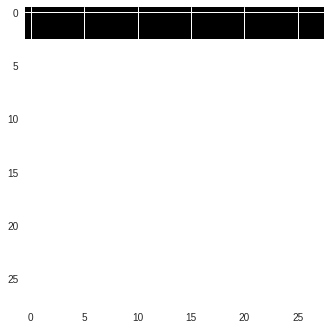

In [30]:
temp = np.zeros((28, 28))
for i in range(3):
  for j in range(28):
    temp[i][j] = float(1)
plt.imshow(temp)
plt.show()

In [0]:
x2_train = np.array([])
x2_train = np.append(x2_train, x1_train)
x2_train = np.reshape(x2_train, (-1, 28, 28, 2))


In [0]:
y2_train = np.array([])
y2_train = np.append(y2_train, y_train)
y2_train = np.reshape(y2_train, (-1, 10))

In [0]:
for i in range(55000):
  x=np.argmax(y2_train[i])
  if(x<9):
    y2_train[i][x] = float(0)
    y2_train[i][x+1] = float(1)
    for j in range(3):
      for k in range(28):
        x2_train[i][j][k][1] = float(1)

In [0]:
x2_test = np.array([])
x2_test = np.append(x2_test, x1_test)
x2_test= np.reshape(x2_test, (-1, 28, 28, 2))

In [0]:
y2_test = np.array([])
y2_test = np.append(y2_test, y_test)
y2_test = np.reshape(y2_test, (-1, 10))

In [0]:
for i in range(10000):
  x=np.argmax(y2_test[i])
  if(x<9):
    y2_test[i][x] = float(0)
    y2_test[i][x+1] = float(1)
    for j in range(3):
      for k in range(28):
        x2_test[i][j][k][1] = float(1)

the dataset with index 2 now contains the edited images with the corrosoponding edited labels

In [0]:
x3_train = np.array([])
x3_train = np.append(x3_train, x1_train)
x3_train = np.append(x3_train, x2_train)
x3_train = np.reshape(x3_train, (-1, 28, 28, 2))

In [0]:
y3_train = np.array([])
y3_train = np.append(y3_train, y_train)
y3_train = np.append(y3_train, y2_train)
y3_train = np.reshape(y3_train, (-1, 10))

In [0]:
x3_test = np.array([])
x3_test = np.append(x3_test, x1_test)
x3_test = np.append(x3_test, x2_test)
x3_test = np.reshape(x3_test, (-1, 28, 28, 2))

In [0]:
y3_test = np.array([])
y3_test = np.append(y3_test, y_test)
y3_test = np.append(y3_test, y2_test)
y3_test = np.reshape(y3_test, (-1, 10))

The dataset with index 3 contains dataset1 and dataset2 appended to each other in that order

In [0]:
p = np.random.permutation(x3_train.shape[0])
x4_train = x3_train[p]
y4_train= y3_train[p]

In [0]:
p = np.random.permutation(x3_test.shape[0])
x4_test = x3_test[p]
y4_test= y3_test[p]

The dataset with index 4 contains dataset1 and dataset2 appended to each other in that order and then shuffled

In [24]:
model4 = alexnet_modified_v1(WIDTH, HEIGHT, 2, LR, output=10)

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


In [25]:
model4.fit({'input': x4_train}, {'targets': y4_train}, n_epoch = 5, validation_set = ({'input': x4_test}, {'targets': y4_test}),
                snapshot_step = 2500, show_metric = True)

Training Step: 8594  | total loss: 0.07026 | time: 88.185s
| Momentum | epoch: 005 | loss: 0.07026 - acc: 0.9869 -- iter: 109952/110000
Training Step: 8595  | total loss: 0.07069 | time: 91.774s
| Momentum | epoch: 005 | loss: 0.07069 - acc: 0.9851 | val_loss: 0.09578 - val_acc: 0.9723 -- iter: 110000/110000
--


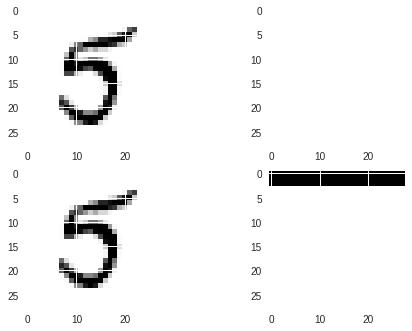

prediction from model 5
answer 5
prediction from model 6
answer 6


In [33]:
temp = np.zeros((28, 28))
for i in range(3):
  for j in range(28):
    temp[i][j] = float(1)

i = np.random.randint(10000)
j = np.random.randint(10000)
plt.subplot(2, 2, 3)
plt.imshow(np.reshape(x_test[i], (28, 28)))
plt.subplot(2, 2, 4)
plt.imshow(temp)
plt.subplot(2, 2, 1)
plt.imshow(np.reshape(x_test[i], (28, 28)))
plt.subplot(2, 2, 2)
plt.imshow( np.zeros((28, 28)))
#plt.imshow(np.reshape(x_test[i], (28, 28)))
plt.show()
#print(i, j)
print("prediction from model", np.argmax( np.round(model4.predict([x1_test[i]])[0]) ))

print("answer", np.argmax(y_test[i]))

print("prediction from model", np.argmax( np.round(model4.predict([x2_test[i]])[0]) ))

print("answer", np.argmax(y2_test[i]))

#Fourth Result and Next Step

The accuracy results of the model with the shuffled dataset (dataset4) were very good, same as the accuracy observed in the second result. Manually checking the predictions of this model also yield the desired results. The predictions for the edited second channel provide the correct result. This manual testing was done on dataset1 and dataset2 so as to get corrosoponding results which are easier to verify. The second channels in the images in the above demonstration are manually added, but are the same as the actual second channels of the image. Displaying the actual second channel as a seperate image would be a tedious progress and this is done for demonstration purposes only.

THe next step is to train the model on the unshuffed data (dataset3), and see if the cnn performs and differently

In [22]:
model5 = alexnet_modified_v1(WIDTH, HEIGHT, 2, LR, output=10)

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


In [23]:
model5.fit({'input': x3_train}, {'targets': y3_train}, n_epoch = 5, validation_set = ({'input': x3_test}, {'targets': y3_test}),
                snapshot_step = 2500, show_metric = True)

Training Step: 8594  | total loss: 0.14955 | time: 89.706s
| Momentum | epoch: 005 | loss: 0.14955 - acc: 0.9760 -- iter: 109952/110000
Training Step: 8595  | total loss: 0.14105 | time: 93.301s
| Momentum | epoch: 005 | loss: 0.14105 - acc: 0.9768 | val_loss: 0.11694 - val_acc: 0.9697 -- iter: 110000/110000
--


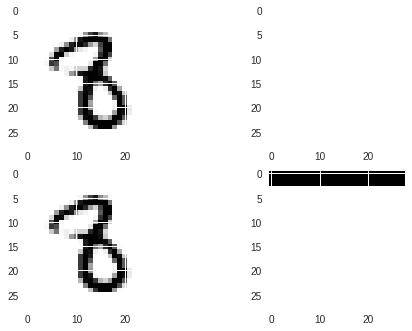

prediction from model 3
answer 8
prediction from model 4
answer 9


In [78]:
temp = np.zeros((28, 28))
for i in range(3):
  for j in range(28):
    temp[i][j] = float(1)

i = np.random.randint(10000)
j = np.random.randint(10000)
plt.subplot(2, 2, 3)
plt.imshow(np.reshape(x_test[i], (28, 28)))
plt.subplot(2, 2, 4)
plt.imshow(temp)
plt.subplot(2, 2, 1)
plt.imshow(np.reshape(x_test[i], (28, 28)))
plt.subplot(2, 2, 2)
plt.imshow( np.zeros((28, 28)))
#plt.imshow(np.reshape(x_test[i], (28, 28)))
plt.show()
#print(i, j)
print("prediction from model", np.argmax( np.round(model5.predict([x1_test[i]])[0]) ))

print("answer", np.argmax(y_test[i]))

print("prediction from model", np.argmax( np.round(model5.predict([x2_test[i]])[0]) ))

print("answer", np.argmax(y2_test[i]))

#Sixth Result and Concolusion

Not shuffling the data does give the same accuracy as all the other succesffull training runs if the metrics from the training run alone are seen. However, manually testing the model reveals that the model does produce wrong answers more often than the model that was trained on shuffled data. However, that observation is completely annecdotal and the observations could be because just a probabalistic anomaly.
It is stil better to shuffle the data, just to be sure that the model does not over fit on any prevailing trends within the data.

All the assumptions made in this experiment were stated with reason and proved through experimental results. The results from the models were satisfactory